In [207]:
import cv2 as cv 
import numpy as np
import pandas as pd
import math

from PIL import Image, ImageDraw, ImageFilter
from matplotlib import pyplot as plt

# draw a blank image, default value of 512x512 with color white or black
def draw_blank_image(x=512,y=512, isWhite=True):
    img = np.zeros([x,y,3], dtype=np.uint8)
    if(isWhite):
        img.fill(255)
    else:
        img.fill(0)
    return img

# draw grid on an image, e.g. blank image 
# #https://stackoverflow.com/questions/44816682/drawing-grid-lines-across-the-image-using-opencv-python
def draw_grid(img, grid_shape, color=(0, 0, 0), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

def draw_radial(img, n_radial=6, color=(0,0,0), thickness=1):
    h, w, _ = img.shape
    isWider = True
    x_adjust = 0
    y_adjust = 0

    if(h>=w):
        isWider = False
    
    radius = min(h,w)/2
    x_center = w/2
    y_center = h/2
    # for x in np.linspace(start=0+x_adjust, stop=w, num=n_radial):
    #     x = int(round(x))
    #     cv.line(img,(0,)) 

    for i in range(0,n_radial):
        theta = 2*math.pi/n_radial*i
        # print('theta = '+str(theta))
        x1 = int(x_center + 2*radius * math.cos(theta))
        x2 = int(x_center - 2*radius * math.cos(theta))
        y1 = int(y_center + 2*radius * math.sin(theta))
        y2 = int(y_center - 2*radius * math.sin(theta))
        # print(str(x1)+", "+str(y1)+", "+str(x2)+", "+str(y2))
        cv.line(img, (x1,y1), (x2,y2), color=color, thickness=thickness)
    return img

def show_rgb_image(image, title=None, conversion=cv.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv.cvtColor(image, conversion)

    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()

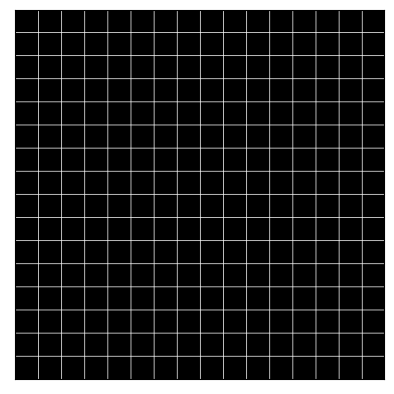

In [208]:
blank = draw_blank_image(isWhite=False)
grid_rect = draw_grid(img=blank,grid_shape=[16,16],color=(255,255,255))

show_rgb_image(grid_rect)

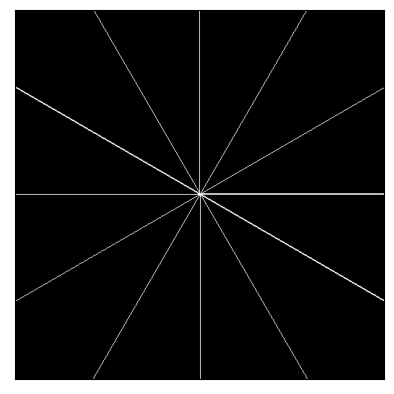

In [209]:
grid_radial = draw_radial(img=draw_blank_image(isWhite=False), n_radial=12,color=(255,255,255))
show_rgb_image(grid_radial)


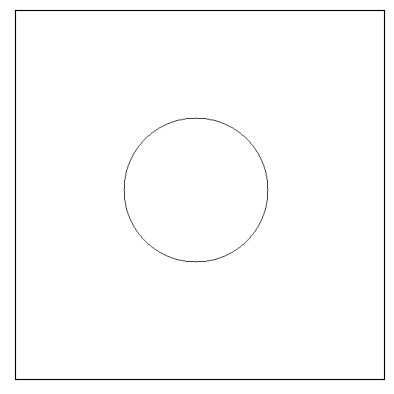

In [210]:
img_circle = draw_blank_image()
cv.circle(img=img_circle, center = (250,250), radius =100, color =(0,0,0), thickness=1)

show_rgb_image(img_circle)

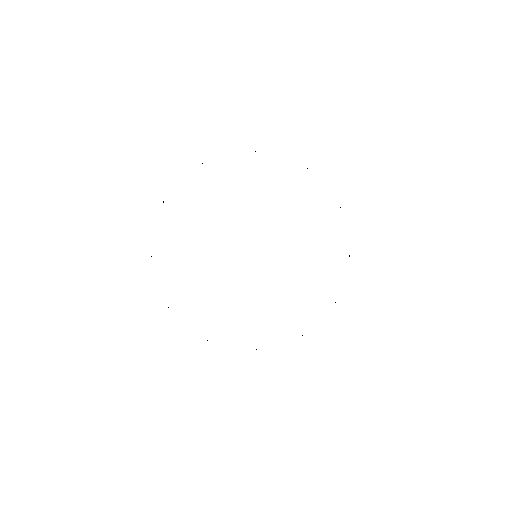

In [211]:
def mergeImageGrid(img, grid):
    img_grid = Image.fromarray(grid)
    img_target = Image.fromarray(img)

    img_blank = Image.fromarray(draw_blank_image())
    img_mask = img_grid.convert("L").resize(img_grid.size)
    return Image.composite(img_target, img_blank, img_mask)

im = mergeImageGrid(img_circle, grid_radial)
display(im)


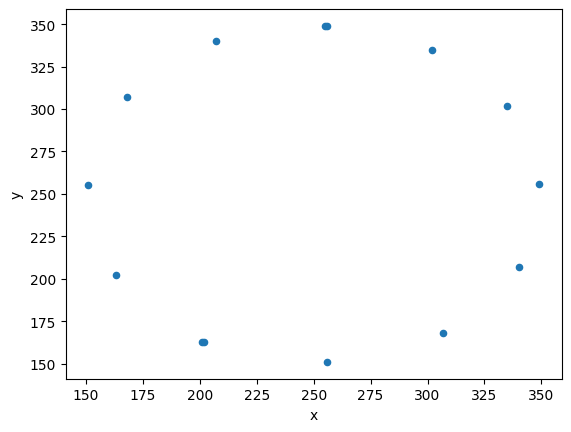

In [212]:
def xyFromPILImage(image):
    img_np = np.array(image)
    x, y = np.where((img_np[:,:,0:3] == [0,0,0]).all(2))

    df = pd.DataFrame({'x':x, 'y':y})
    df.plot('x','y',kind='scatter')
    return df

df_circle = xyFromPILImage(im)